# Portfolio Setup

This notebook aims to show how to setup your environment to be able to perform basic portfolio calculations and visualisations without using purpose built libraries.

In [2]:
%matplotlib notebook
import pandas as pd
import sqlite3 as sq
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Getting Data

There are are a few things to consider when conducting portfolio analysis:
- what is your security universe? Do you want only domestic equities or international? 
- If using international you need to consider how to manage cash and FX, etc
- where to get the data from and what frequency do you want it? 
- how to effectively store this data for reusability and consistency
- what format do we want returned? json, csv?

In [57]:
# lets use AlphaVantage to download security data (https://www.alphavantage.co/documentation/)
def get_market_data(ticker, output_format, data_field, api_key, output_size):
    url_raw = 'https://www.alphavantage.co/query?function={field}&symbol={symb}&apikey={api_key}&datatype={fmt}&outputsize={output_size}'
    url_clean = url_raw.format(field=data_field, symb=ticker, api_key=api_key, fmt=output_format, output_size=output_size)
    mkt_data = requests.get(url_clean)
    return mkt_data

# set param's for download
tickers = ['bhp.ax','nab.ax','flt.ax','csl.ax']
data_field = 'TIME_SERIES_DAILY_ADJUSTED'
output_format = 'csv' # can be json or csv
output_size = 'compact' # can be compact or full
api_key = '<add yours here>'

# make the download for only one security this time
sec_data = get_market_data(tickers[0], output_format, data_field, api_key, output_size)

# using the io library, we can convert the request data to pandas DataFrame
sec_df = pd.read_csv(io.BytesIO(sec_data.content))

# lets add the ticker into a column and show head
sec_df['ticker'] = tickers[0]
sec_df.head(10)

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,ticker
0,2018-09-21,33.20,33.47,33.150,33.33,33.33,1881518,0.0,1.0,bhp.ax
1,2018-09-20,32.85,32.94,32.660,32.77,32.77,9952932,0.0,1.0,bhp.ax
2,2018-09-19,32.00,32.45,32.000,32.40,32.40,7523703,0.0,1.0,bhp.ax
3,2018-09-18,31.22,31.48,31.200,31.48,31.48,6622664,0.0,1.0,bhp.ax
4,2018-09-17,31.55,31.73,31.470,31.61,31.61,5603741,0.0,1.0,bhp.ax
5,2018-09-14,31.40,31.86,31.390,31.82,31.82,7633977,0.0,1.0,bhp.ax
6,2018-09-13,31.20,31.75,31.105,31.31,31.31,6140427,0.0,1.0,bhp.ax
7,2018-09-12,31.06,31.10,30.750,31.10,31.10,5510402,0.0,1.0,bhp.ax
8,2018-09-11,30.87,31.20,30.700,31.20,31.20,4438179,0.0,1.0,bhp.ax
9,2018-09-10,31.18,31.38,30.960,31.20,31.20,3353064,0.0,1.0,bhp.ax


# Storing Data

when storing data we will need to have a normalised format to help database scalability. Things to consider:

- security codes to be stores
- pricing fields to be stored
- if using multiple vendors, how to store
- do we want to use an ORM?
- do we normalise tickers or leave them as we do with the request
- what database do we want to use? sqlite3
- how lazy do we want to be?

In [61]:
# lets use a function to initiate a sqlite3 database and store data in it
def update_sec_db(sec_data, db_path, table_name, append_replace):
    
    # use context manager to managew conextion
    with sq.connect(db_path) as conn:
        
        # insert data into db
        sec_data.to_sql(name=table_name, con=conn, if_exists=append_replace, index=False)
        
        # for good measure lets redownload the data inserted
        sql='select * from {} limit 10;'.format(table_name)
        db_data = pd.read_sql(sql, con=conn)
        
        # return this data
        return db_data

test_db_insert = update_sec_db(sec_df, 'test.sqlite3','sec_eod','replace')
test_db_insert

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,ticker
0,2018-09-21,33.20,33.47,33.150,33.33,33.33,1881518,0.0,1.0,bhp.ax
1,2018-09-20,32.85,32.94,32.660,32.77,32.77,9952932,0.0,1.0,bhp.ax
2,2018-09-19,32.00,32.45,32.000,32.40,32.40,7523703,0.0,1.0,bhp.ax
3,2018-09-18,31.22,31.48,31.200,31.48,31.48,6622664,0.0,1.0,bhp.ax
4,2018-09-17,31.55,31.73,31.470,31.61,31.61,5603741,0.0,1.0,bhp.ax
5,2018-09-14,31.40,31.86,31.390,31.82,31.82,7633977,0.0,1.0,bhp.ax
6,2018-09-13,31.20,31.75,31.105,31.31,31.31,6140427,0.0,1.0,bhp.ax
7,2018-09-12,31.06,31.10,30.750,31.10,31.10,5510402,0.0,1.0,bhp.ax
8,2018-09-11,30.87,31.20,30.700,31.20,31.20,4438179,0.0,1.0,bhp.ax
9,2018-09-10,31.18,31.38,30.960,31.20,31.20,3353064,0.0,1.0,bhp.ax


# Consume data

For good measure, lets visualise some of this data to make sure it works

<IPython.core.display.Javascript object>


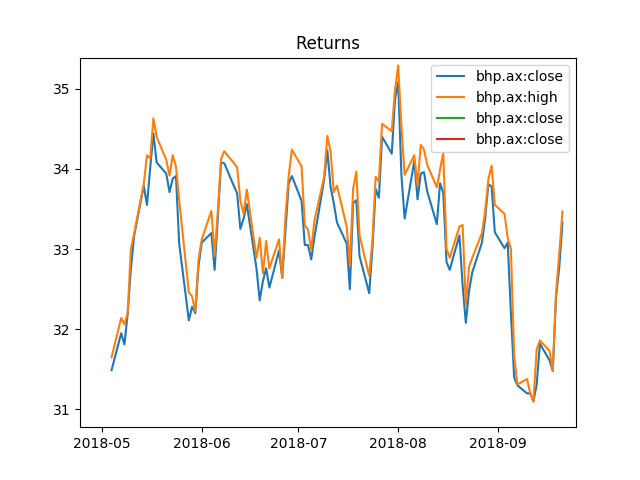

In [4]:
# lets just grab all the data we just imported into sqlit3
def plot_from_db(tickers, fields):
    for ticker in tickers:
        with sq.connect('test.sqlite3') as conn:
            sql = "select * from sec_eod where ticker = '{}';".format(ticker)
            sec_data_df = pd.read_sql(sql, con=conn, index_col='timestamp')

        sec_data_df.index = pd.to_datetime(sec_data_df.index)

        for field in fields:
            plt.plot(sec_data_df[field], label='{sec}:{fld}'.format(sec=ticker, fld=field))

    plt.legend()
    plt.show()

plot_from_db(['bhp.ax'],['close','high'])

# Do some analysis

<IPython.core.display.Javascript object>


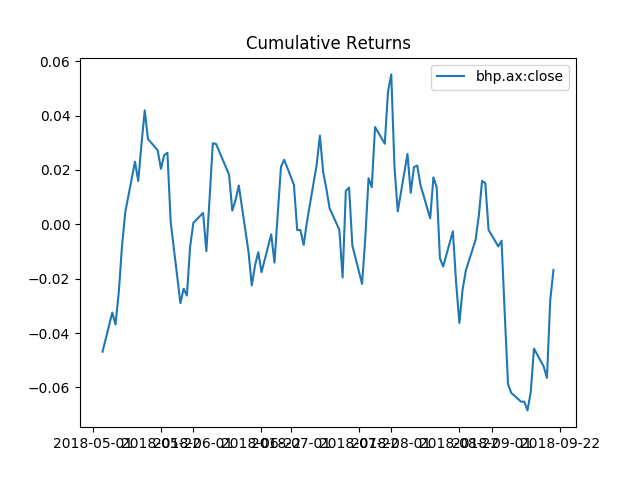

In [9]:
def plot_rets(tickers, fields, cum=False):
    for ticker in tickers:
        with sq.connect('test.sqlite3') as conn:
            sql = "select * from sec_eod where ticker = '{}';".format(ticker)
            sec_data_df = pd.read_sql(sql, con=conn, index_col='timestamp')

        sec_data_df.index = pd.to_datetime(sec_data_df.index)

        for field in fields:
            if cum:
                plot_df = sec_data_df[field].pct_change().cumsum()
                title = "Cumulative Returns"
            else:
                plot_df = sec_data_df[field].pct_change()
                title = "Returns"
            
            plt.plot(plot_df, label='{sec}:{fld}'.format(sec=ticker, fld=field))
    
    plt.title(title)
    plt.legend()
    plt.show()

    
plot_rets(['bhp.ax'],['adjusted_close'], cum=True)

# Lets do this for multiple securities

<IPython.core.display.Javascript object>


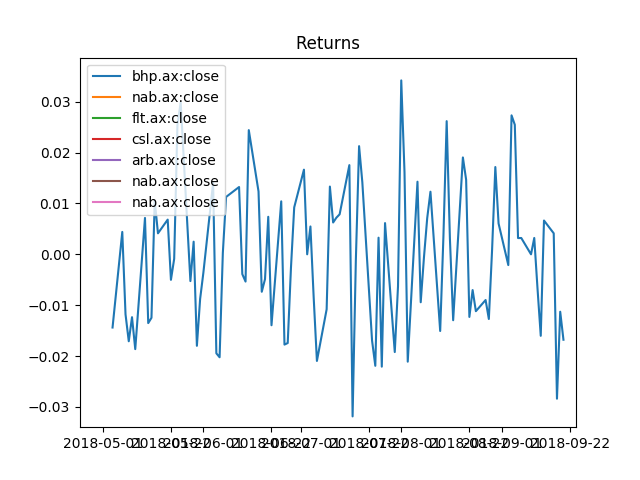

In [11]:
def get_market_data2(ticker, output_format, data_field, api_key, output_size):
    url_raw = 'https://www.alphavantage.co/query?function={field}&symbol={symb}&apikey={api_key}&datatype={fmt}&outputsize={output_size}'
    url_clean = url_raw.format(field=data_field, symb=ticker, api_key=api_key, fmt=output_format, output_size=output_size)
    mkt_data = requests.get(url_clean)
    return mkt_data


def update_sec_db2(sec_data, db_path, table_name, append_replace):
    with sq.connect(db_path) as conn:
        sec_data.to_sql(name=table_name, con=conn, if_exists=append_replace, index=False)
    return

def plot_rets2(tickers, fields, db_path, cum=False):
    for ticker in tickers:
        with sq.connect(db_path) as conn:
            sql = "select * from sec_eod where ticker = '{}';".format(ticker)
            sec_data_df = pd.read_sql(sql, con=conn, index_col='timestamp')

        sec_data_df.index = pd.to_datetime(sec_data_df.index)

        for field in fields:
            if cum:
                plot_df = sec_data_df[field].pct_change().cumsum()
                title = "Cumulative Returns"
            else:
                plot_df = sec_data_df[field].pct_change()
                title = "Returns"
            
            plt.plot(plot_df, label='{sec}:{fld}'.format(sec=ticker, fld=field))
    
    plt.title(title)
    plt.legend()
    plt.show()
    return

# now lets set variables and run
tickers = ['bhp.ax','nab.ax','flt.ax','csl.ax','arb.ax']
data_field = 'TIME_SERIES_DAILY_ADJUSTED'
output_format = 'csv' # can be json or csv
output_size = 'full' # can be compact or full
db_path = 'test2.sqlite3'
tbl_name = 'sec_eod'
append_replace = 'append'

for ticker in tickers:
    sec_data = get_market_data2(ticker, output_format, data_field, api_key, output_size)
    sec_df = pd.read_csv(io.BytesIO(sec_data.content))
    sec_df['ticker'] = ticker    
    update_sec_db2(sec_df, db_path, tbl_name, append_replace)

plot_rets2(tickers,['close'])

<IPython.core.display.Javascript object>


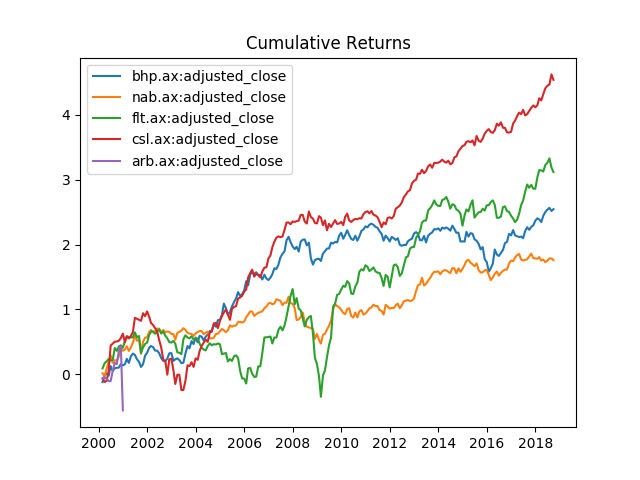

In [29]:
def plot_rets3(tickers, fields, db_path, per='M',  cum=False):
    for ticker in tickers:
        with sq.connect(db_path) as conn:
            sql = "select * from sec_eod where ticker = '{}';".format(ticker)
            sec_data_df = pd.read_sql(sql, con=conn, index_col='timestamp')

        sec_data_df.index = pd.to_datetime(sec_data_df.index)
        
        if per.lower() in ['m','mth','month','monthly']:
            sec_data_df = sec_data_df.resample('M').last() 
        
        elif per.lower() in ['y','yr','year','yearly','annual','a']:
            sec_data_df = sec_data_df.resample('Y').last()
            
        for field in fields:
            if cum:
                plot_df = sec_data_df[field].pct_change().cumsum()
                title = "Cumulative Returns"
            else:
                plot_df = sec_data_df[field].pct_change()
                title = "Returns"
            
            plt.plot(plot_df, label='{sec}:{fld}'.format(sec=ticker, fld=field))
    
    plt.title(title)
    plt.legend()
    plt.show()
    return

tickers = ['bhp.ax','nab.ax','flt.ax','csl.ax','arb.ax']
fields = ['adjusted_close']
db_path = 'test2.sqlite3'
per = 'mth'
cum = True

plot_rets3(tickers,fields, db_path, per, True)

<IPython.core.display.Javascript object>


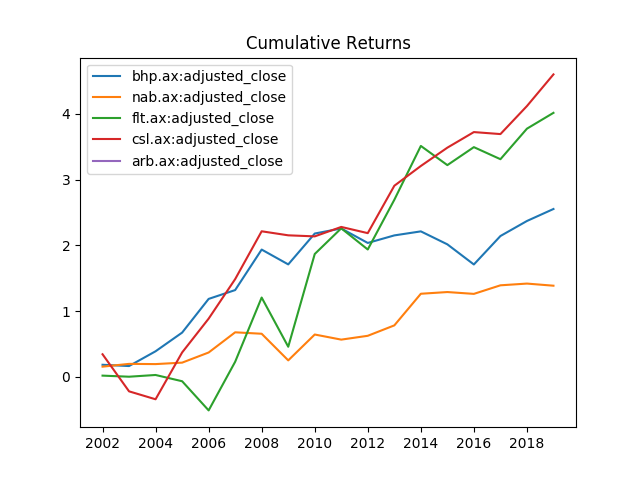

In [30]:
plot_rets3(tickers,fields, db_path, 'Y', True)